# ERA5 MSLP for SOCAT fCO2-->pCO2

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import numpy.ma as ma
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
%config InlineBackend.print_figure_kwargs = {'dpi':300, 'bbox_inches': 'tight'}
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
import scipy
import sklearn.linear_model 
import pickle

Need sea level pressure and sea surface temperature to convert to pCO2

In [2]:
#era5 = xr.open_dataset('/data/artemis/workspace/gloege/data/ERA5_MSLP/ERA5_MSLP.nc')
era5 = xr.open_dataset('/data/artemis/observations/ERA5_MSLP/ERA5_MSLP_1979-2021.nc')

In [3]:
mslp = era5.msl/100 # Pascals to hPa
long = mslp.longitude
lat = mslp.latitude
etime = era5.time
expver = mslp.expver

In [7]:
###################################
socat = xr.open_dataset('/data/artemis/observations/SOCAT/originals/SOCATv2021_tracks_gridded_monthly.nc')
ylat = socat.ylat
xlon = socat.xlon

In [4]:
# Need pressure regridded to SOCAT grid and time
import xesmf as xe

In [5]:
print(long)

<xarray.DataArray 'longitude' (longitude: 1440)>
array([0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.5925e+02, 3.5950e+02,
       3.5975e+02], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Attributes:
    units:      degrees_east
    long_name:  longitude


In [8]:
sgrid = xr.Dataset({'lat':(['lat'],ylat.values),'lon':(['lon'],xlon.values)})
egrid = xr.Dataset({'lat':(['lat'],lat.values),'lon':(['lon'],long.values)})
slp = xr.Dataset({'mslp':(['time','lat','lon'],mslp[:,0,:,:].values),'time':(['time'],etime.values),'lat':(['lat'],lat.values),'lon':(['lon'],long.values)})

In [9]:
regridder = xe.Regridder(slp, sgrid, 'bilinear','periodic')

Create weight file: bilinear_721x1440_180x360_peri.nc


In [10]:
mslp_out = regridder(mslp)

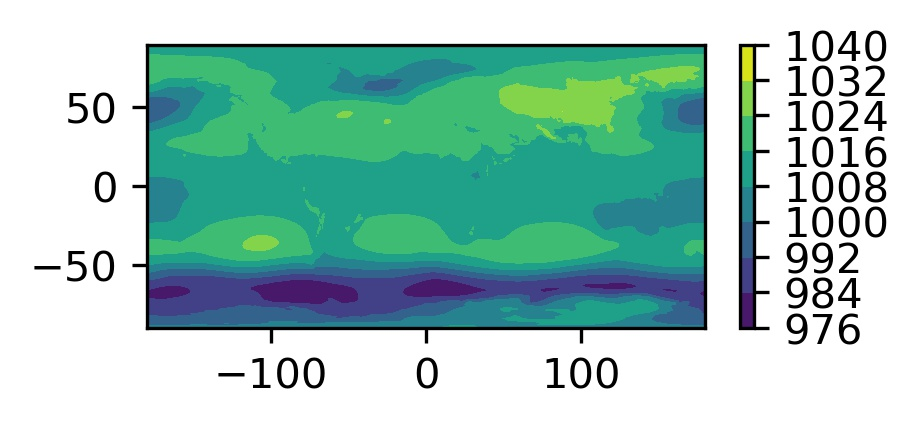

In [11]:
# Let's pick a month to make sure it looks reasonable:
########################################################

fig = plt.figure(figsize=(3,1.25))
plt.contourf(mslp_out.lon,mslp_out.lat,mslp_out[25,0,:,:])
plt.colorbar()

In [12]:
mslp_write_out = xr.Dataset({
                        'mslp':(["time","lat","lon"],mslp_out[:,0,:,:])},
                        coords={'time': (['time'],slp.time.values),
                        'lat': (['lat'],mslp_out.lat.values),
                        'lon':(['lon'],mslp_out.lon.values)})
mslp_write_out.mslp.attrs['units'] = 'hPa'  
mslp_write_out.attrs['created'] = "Val Bennington Jan 20, 2022 xesmf bilinear interpolation from /data/artemis/observations/ERA5_MSLP/ERA5_MSLP_1979-2021.nc"
    # Save to netcdf
mslp_write_out.to_netcdf('/data/artemis/observations/ERA5_MSLP/ERA5_MSLP_1x1_1979-2021.nc') 